In [1]:
#%env CUDA_VISIBLE_DEVICES=2

import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import time
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image

In [2]:
import syft as sy  # <-- NEW: import the Pysyft library


W0819 12:37:22.215779 48816 secure_random.py:26] Falling back to insecure randomness since the required custom op could not be found for the installed version of TensorFlow. Fix this by compiling custom ops. Missing file was 'c:\users\edgarin\.conda\envs\finder-drone-env\lib\site-packages\tf_encrypted/operations/secure_random/secure_random_module_tf_1.14.0.so'
W0819 12:37:22.243762 48816 deprecation_wrapper.py:119] From c:\users\edgarin\.conda\envs\finder-drone-env\lib\site-packages\tf_encrypted\session.py:26: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.



In [3]:
hook = sy.TorchHook(torch)  # <-- NEW: hook PyTorch ie add extra functionalities to support Federated Learning
bob = sy.VirtualWorker(hook, id="bob")  # <-- NEW: define remote worker bob
alice = sy.VirtualWorker(hook, id="alice")  # <-- NEW: and alice

In [4]:
dataset = 'mycats'  # Dataset name
dataset_dir = 'dataset'  # Dataset directory
train_results_dir = 'train_results_fed'

In [5]:
# Applying Transforms to the Data
image_transforms = { 
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size=256, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=180),
        transforms.RandomHorizontalFlip(),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(size=256),
        transforms.CenterCrop(size=224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ])
}

In [6]:
# Load the Data

# Set train and valid directory paths
train_directory = os.path.join(dataset_dir, 'train')
valid_directory = os.path.join(dataset_dir, 'valid')
test_directory = os.path.join(dataset_dir, 'test')

# Batch size
bs = 32

# Number of classes
# num_classes = len(os.listdir(valid_directory))-1  #10#2#257
num_classes = len(os.listdir(valid_directory))  #10#2#257
print(num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid']),
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

#data = {
#    'train': datasets.ImageFolder(root=train_directory),
#    'valid': datasets.ImageFolder(root=valid_directory),
#    'test': datasets.ImageFolder(root=test_directory)
#}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])
test_data_size = len(data['test'])



4
{0: 'juana', 1: 'lily', 2: 'whisky', 3: 'yayo'}


In [7]:
#The list of arguments for our program. We will be needing most of them soon.
class Arguments():
    def __init__(self):
        self.batch_size = 1
        self.test_batch_size = 5
        self.valid_batch_size = 5
        self.epochs = 5
        self.lr = 0.01
        self.momentum = 0.5
        self.no_cuda = False
        #self.federate_after_n_batches = 15000
        self.seed = 1
        self.log_interval = 10
        self.save_model = False
        
args = Arguments()

#use_cuda = not args.no_cuda and torch.cuda.is_available()
use_cuda = False

torch.manual_seed(args.seed)

device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}

In [8]:
# The easy way 
# fed_train_dataset = data['train']
# fed_train_dataset.data = fed_train_dataset.targets = True  # Comment this line to trigger the PR error

In [9]:
# Create iterators for the Data loaded using DataLoader module
#train_data_loader = sy.FederatedDataLoader(fed_train_dataset.federate((bob, alice)), batch_size=args.batch_size, shuffle=True, **kwargs)
train_data_loader = DataLoader(data['train'], batch_size=args.batch_size, shuffle=True, **kwargs)
valid_data_loader = DataLoader(data['valid'], batch_size=bs, shuffle=True)
test_data_loader = DataLoader(data['test'], batch_size=bs, shuffle=True)

In [10]:
train_data_size, valid_data_size, test_data_size

(548, 186, 179)

In [11]:
resnet50_untrained = models.resnet50(pretrained=False)
print(resnet50_untrained)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

In [12]:
resnet50_untrained.fc.in_features

2048

In [13]:
# Load pretrained ResNet50 Model
# resnet50 = models.resnet50(pretrained=True)
# resnet50 = resnet50.to('cuda:0')
# Freeze model parameters
#for param in resnet50.parameters():
    #param.requires_grad = False

In [14]:
resnet50_wll = models.resnet50(pretrained=True)

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

resnet50_wll.fc = Identity()

# Freeze model parameters
for param in resnet50_wll.parameters():
    param.requires_grad = False

In [15]:
# Change the final layer of ResNet50 Model for Transfer Learning
# fc_inputs = resnet50_untrained.fc.in_features
fc_inputs = 2048

model_ll = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, num_classes), # Since 10 possible outputs
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)

for param in model_ll.parameters():
    param.requires_grad = True

# Convert model to be used on GPU
#resnet50 = resnet50.to('cuda:0')


In [16]:
# Define Optimizer and Loss Function
loss_func = nn.NLLLoss()
optimizer = optim.Adam(model_ll.parameters())

In [17]:

    
device

device(type='cpu')

In [18]:
def train_and_validate(model_ll, loss_criterion, optimizer, epochs=25):
    '''
    Function to train and validate
    Parameters
        :param model: Model to train and validate
        :param loss_criterion: Loss Criterion to minimize
        :param optimizer: Optimizer for computing gradients
        :param epochs: Number of epochs (default=25)
  
    Returns
        model: Trained Model with best validation accuracy
        history: (dict object): Having training loss, accuracy and validation loss, accuracy
    '''
    
    start = time.time()
    history = []
    best_acc = 0.0

    for epoch in range(epochs):
        epoch_start = time.time()
        print("Epoch: {}/{}".format(epoch+1, epochs))
        
        # Set to training mode
        model_ll.train()
        
        # Loss and Accuracy within the epoch
        train_loss = 0.0
        train_acc = 0.0
        
        valid_loss = 0.0
        valid_acc = 0.0
        
        for i, (inputs, labels) in enumerate(train_data_loader):
            print('Batch ', i)
            
            ### model.send(inputs.location) # <-- NEW: send the model to the right location
            
            # inputs = inputs.to(device)
            # labels = labels.to(device)
            
            # Clean existing gradients
            optimizer.zero_grad()
            
            # Forward pass - compute outputs on input data using the model
            #outputs = model(inputs)
            tworker = bob if i % 2 == 0 else alice
            rwll_outputs = resnet50_wll(inputs)
            #print('rwll_outputs shape: ', rwll_outputs.shape)
            
            rwll_outputs = rwll_outputs.send(tworker)
            #print('rwll_outputs sent: ', rwll_outputs)
            model_ll = model_ll.send(tworker)
            outputs = model_ll.forward(rwll_outputs)
            
            labels = labels.send(tworker)
                        
            # Compute loss
            loss = loss_criterion(outputs, labels)
            
            # Backpropagate the gradients
            loss.backward()            
            
            model_ll = model_ll.get() # <-- NEW: get the model back
            labels = labels.get()            
            outputs = outputs.get()
            loss = loss.get()  # <-- NEW: get the loss back
            
            # Update the parameters
            optimizer.step()
            
            # Compute the total loss for the batch and add it to train_loss
            train_loss += loss.item() * inputs.size(0)
            
            
            
            # Compute the accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))
            
            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            
            # Compute total accuracy in the whole batch and add to train_acc
            train_acc += acc.item() * inputs.size(0)
            
            #print("Batch number: {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}".format(i, loss.item(), acc.item()))

            
        
        # Find average training loss and training accuracy
        avg_train_loss = train_loss/train_data_size 
        avg_train_acc = train_acc/train_data_size

        # Find average training loss and training accuracy
        avg_valid_loss = 0 # valid_loss/valid_data_size 
        avg_valid_acc = 0 # valid_acc/valid_data_size

        history.append([avg_train_loss, avg_valid_loss, avg_train_acc, avg_valid_acc])
                
        epoch_end = time.time()
    
        print("Epoch : {:03d}, Training: Loss: {:.4f}, Accuracy: {:.4f}%, \n\t\tValidation : Loss : {:.4f}, Accuracy: {:.4f}%, Time: {:.4f}s".format(epoch, avg_train_loss, avg_train_acc*100, avg_valid_loss, avg_valid_acc*100, epoch_end-epoch_start))
        
        # Save if the model has best accuracy till now
        torch.save(model_ll, train_results_dir + '/' + dataset+'_model_ll_'+str(epoch)+'.pt')
            
    return model_ll, history
    

In [19]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device: ', device)
# Print the model to be trained
#summary(resnet50, input_size=(3, 224, 224), batch_size=bs, device='cuda')

# Train the model for 25 epochs
num_epochs = 1
trained_model_ll, history = train_and_validate(model_ll, loss_func, optimizer, num_epochs)

trained_model = resnet50_wll
trained_model.fc = trained_model_ll

torch.save(history, train_results_dir + '/' + dataset+'_history.pt')

device:  cpu
Epoch: 1/1
Batch  0
rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:32945671469 -> bob:72161374688]
About to compute loss
Batch  1
rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:68371051152 -> alice:80484866777]
About to compute loss
Batch  2
rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:59447252542 -> bob:51392701680]
About to compute loss
Batch  3
rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:4027388858 -> alice:82466299181]
About to compute loss
Batch  4
rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:31461363006 -> bob:66795133423]
About to compute loss
Batch  5
rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:20119685399 -> alice:78769459774]
About to compute loss
Batch  6
rwll_outputs shape:  torch

rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:84880879681 -> bob:11724525168]
About to compute loss
Batch  53
rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:46340109054 -> alice:37744791176]
About to compute loss
Batch  54
rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:45381604093 -> bob:34806239120]
About to compute loss
Batch  55
rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:13372967763 -> alice:47701367155]
About to compute loss
Batch  56
rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:82767142472 -> bob:179121500]
About to compute loss
Batch  57
rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:56297923979 -> alice:75832610464]
About to compute loss
Batch  58
rwll_outputs shape:  torch.Size([1, 2048])
rwll_output

rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:88723378616 -> bob:23192401424]
About to compute loss
Batch  105
rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:45385358401 -> alice:26588549279]
About to compute loss
Batch  106
rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:94904877570 -> bob:99579693320]
About to compute loss
Batch  107
rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:3236705523 -> alice:20570634627]
About to compute loss
Batch  108
rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:73025769898 -> bob:88975115070]
About to compute loss
Batch  109
rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:55945440350 -> alice:79026670182]
About to compute loss
Batch  110
rwll_outputs shape:  torch.Size([1, 2048])
rwll

rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:95187435223 -> bob:99293344761]
About to compute loss
Batch  157
rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:84501885795 -> alice:64297251355]
About to compute loss
Batch  158
rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:58790394777 -> bob:48482090212]
About to compute loss
Batch  159
rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:63857297219 -> alice:3667706349]
About to compute loss
Batch  160
rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:81464957996 -> bob:47595682748]
About to compute loss
Batch  161
rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:90961235299 -> alice:41378318459]
About to compute loss
Batch  162
rwll_outputs shape:  torch.Size([1, 2048])
rwll

rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:67132595211 -> bob:43566571796]
About to compute loss
Batch  209
rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:34852108040 -> alice:52927638723]
About to compute loss
Batch  210
rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:28486546284 -> bob:57440061725]
About to compute loss
Batch  211
rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:61751981912 -> alice:27653667218]
About to compute loss
Batch  212
rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:64628282271 -> bob:16947117556]
About to compute loss
Batch  213
rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:25441027319 -> alice:49380950671]
About to compute loss
Batch  214
rwll_outputs shape:  torch.Size([1, 2048])
rwl

rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:21752992763 -> bob:21890170416]
About to compute loss
Batch  261
rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:22268417272 -> alice:9743634612]
About to compute loss
Batch  262
rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:95586658684 -> bob:42217560263]
About to compute loss
Batch  263
rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:24779616430 -> alice:63264413051]
About to compute loss
Batch  264
rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:82162876822 -> bob:1168248921]
About to compute loss
Batch  265
rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:16504999664 -> alice:86036731632]
About to compute loss
Batch  266
rwll_outputs shape:  torch.Size([1, 2048])
rwll_

rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:34676761062 -> bob:5805625502]
About to compute loss
Batch  313
rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:18204432739 -> alice:99262791786]
About to compute loss
Batch  314
rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:31385206747 -> bob:810788484]
About to compute loss
Batch  315
rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:41529531094 -> alice:30738936444]
About to compute loss
Batch  316
rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:92685710195 -> bob:18387965675]
About to compute loss
Batch  317
rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:63012598164 -> alice:62176448355]
About to compute loss
Batch  318
rwll_outputs shape:  torch.Size([1, 2048])
rwll_o

rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:4219635851 -> bob:600177159]
About to compute loss
Batch  365
rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:13748528186 -> alice:42426061456]
About to compute loss
Batch  366
rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:60762711443 -> bob:17187110970]
About to compute loss
Batch  367
rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:43881708700 -> alice:36070875567]
About to compute loss
Batch  368
rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:16879871673 -> bob:45659446502]
About to compute loss
Batch  369
rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:68658908047 -> alice:60914566895]
About to compute loss
Batch  370
rwll_outputs shape:  torch.Size([1, 2048])
rwll_o

rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:52223445282 -> bob:59178503791]
About to compute loss
Batch  417
rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:47144780557 -> alice:69572895745]
About to compute loss
Batch  418
rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:11716431209 -> bob:56961747389]
About to compute loss
Batch  419
rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:11482244757 -> alice:51184789964]
About to compute loss
Batch  420
rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:23699532826 -> bob:50305849880]
About to compute loss
Batch  421
rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:76040477741 -> alice:3401140283]
About to compute loss
Batch  422
rwll_outputs shape:  torch.Size([1, 2048])
rwll

rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:14655210983 -> bob:71847228168]
About to compute loss
Batch  469
rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:595652650 -> alice:13573153089]
About to compute loss
Batch  470
rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:58686636010 -> bob:86759044154]
About to compute loss
Batch  471
rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:98391848949 -> alice:54131869315]
About to compute loss
Batch  472
rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:60217370013 -> bob:23393384753]
About to compute loss
Batch  473
rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:77609848597 -> alice:88851264830]
About to compute loss
Batch  474
rwll_outputs shape:  torch.Size([1, 2048])
rwll_

rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:74319663577 -> bob:65070223077]
About to compute loss
Batch  521
rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:44464155383 -> alice:84594318796]
About to compute loss
Batch  522
rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:23220138726 -> bob:33097444773]
About to compute loss
Batch  523
rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:87388250720 -> alice:296771764]
About to compute loss
Batch  524
rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:69662549078 -> bob:68266460]
About to compute loss
Batch  525
rwll_outputs shape:  torch.Size([1, 2048])
rwll_outputs sent:  (Wrapper)>[PointerTensor | me:39294382627 -> alice:92614196193]
About to compute loss
Batch  526
rwll_outputs shape:  torch.Size([1, 2048])
rwll_out

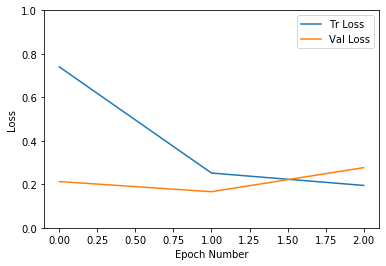

In [22]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.savefig(train_results_dir + '/' + dataset+'_loss_curve.png')
plt.show()


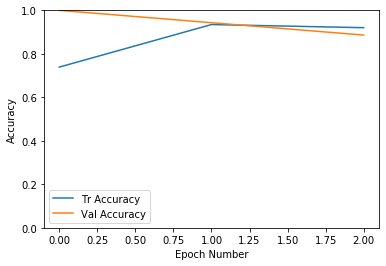

In [24]:
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig(train_results_dir + '/' + dataset+'_accuracy_curve.png')
plt.show()

In [25]:
 def computeTestSetAccuracy(model, loss_criterion):
    '''
    Function to compute the accuracy on the test set
    Parameters
        :param model: Model to test
        :param loss_criterion: Loss Criterion to minimize
    '''

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    test_acc = 0.0
    test_loss = 0.0

    # Validation - No gradient tracking needed
    with torch.no_grad():

        # Set to evaluation mode
        model.eval()

        # Validation loop
        for j, (inputs, labels) in enumerate(test_data_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass - compute outputs on input data using the model
            outputs = model(inputs)

            # Compute loss
            loss = loss_criterion(outputs, labels)

            # Compute the total loss for the batch and add it to valid_loss
            test_loss += loss.item() * inputs.size(0)

            # Calculate validation accuracy
            ret, predictions = torch.max(outputs.data, 1)
            correct_counts = predictions.eq(labels.data.view_as(predictions))

            # Convert correct_counts to float and then compute the mean
            acc = torch.mean(correct_counts.type(torch.FloatTensor))

            # Compute total accuracy in the whole batch and add to valid_acc
            test_acc += acc.item() * inputs.size(0)

            print("Test Batch number: {:03d}, Test: Loss: {:.4f}, Accuracy: {:.4f}".format(j, loss.item(), acc.item()))

    # Find average test loss and test accuracy
    avg_test_loss = test_loss/test_data_size 
    avg_test_acc = test_acc/test_data_size

    print("Test accuracy : " + str(avg_test_acc))


In [29]:
def predict(model, test_image_name):
    '''
    Function to predict the class of a single test image
    Parameters
        :param model: Model to test
        :param test_image_name: Test image

    '''
    
    transform = image_transforms['test']

    test_image = Image.open(test_image_name)
    plt.imshow(test_image)
    
    prediction_start = time.time()
    test_image_tensor = transform(test_image)

    if device == 'cuda': #torch.cuda.is_available():
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224).cuda()
    else:
        test_image_tensor = test_image_tensor.view(1, 3, 224, 224)
    
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(test_image_tensor)
        print('Raw output', out)
        print('Out requires_grad', out.requires_grad)
        ps = torch.exp(out)
        # print(ps*100)
        topk, topclass = ps.topk(3, dim=1)
        print(topclass)
        # print("Predcition:", idx_to_class[topclass.cpu().numpy()[0][0]], ", Score: ", topk.cpu().numpy()[0][0])
        #for i in range(3):
        #    print("Predcition", i+1, ":", idx_to_class[topclass.cpu().numpy()[0][i]], ", Score: ", topk.cpu().numpy()[0][i])

    prediction_end = time.time()
    return prediction_end - prediction_start


Raw output tensor([[0.4929, 0.7734, 1.0200,  ..., 0.4089, 0.5304, 0.2396]],
       device='cuda:0')
Out requires_grad False
tensor([[1064, 2018, 1783]], device='cuda:0')


0.0929422378540039

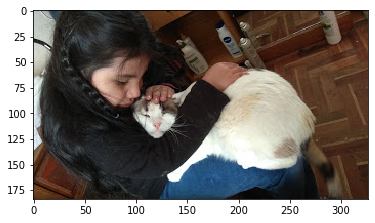

In [30]:
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()
        
    def forward(self, x):
        return x

resnet50.fc = Identity()

####
device = 'cuda'
model = resnet50
model.to(device)
predict(model, 'images/lila-2.jpg')





dataset/test/whisky/whisky2470.jpg
Predcition: whisky , Score:  0.99214935
Time: 0.4932s
Expected:  whisky


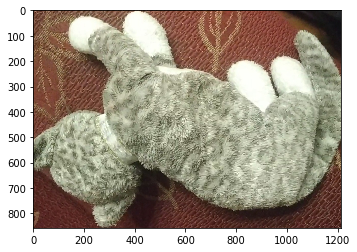

In [31]:
# Test a particular model on a test image
model_ll = torch.load(train_results_dir + '/mycats_model_1.pt')
model = resnet50_wll
model.fc = model_ll
#predict(model, 'pixabay-test-animals/triceratops-954293_640.jpg')
expected_class_index = np.random.randint(0, len(idx_to_class))
expected_label = idx_to_class[expected_class_index]

def get_test_file():
    # return "images/lila-2.jpg"
    folder_path = "{}/test/{}".format(dataset_dir, expected_label)
    files = os.listdir(folder_path)
    index = np.random.randint(0, len(files))
    return folder_path + '/' + files[index]

file = get_test_file()
print(file)
prediction_start = time.time()
predict(model, file)
print("Time: {:.4f}s".format(time.time()-prediction_start))
print('Expected: ', expected_label)
# Load Data from folders
# computeTestSetAccuracy(model, loss_func)
        
        

dataset/test/whisky/whisky1050.jpg
Predcition: whisky , Score:  0.98057854
dataset/test/whisky/whisky2260.jpg
Predcition: whisky , Score:  0.98909855
dataset/test/whisky/whisky2470.jpg
Predcition: whisky , Score:  0.99214935
dataset/test/whisky/whisky430.jpg
Predcition: whisky , Score:  0.98304456
dataset/test/whisky/whisky1490.jpg
Predcition: whisky , Score:  0.96524876
Avg Time: 0.4226s


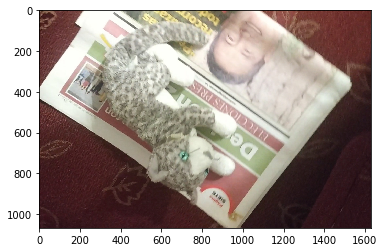

In [32]:

total_time = 0
total_n = 5
for i in range(total_n):
    file = get_test_file()
    print(file)
    #prediction_start = time.time()
    predict_time = predict(model, file)
    #predict_time = time.time()-prediction_start
    total_time += predict_time
    
print("Avg Time: {:.4f}s".format(total_time/total_n))


In [21]:
computeTestSetAccuracy(model, loss_func)

Test Batch number: 000, Test: Loss: 0.1047, Accuracy: 0.9375
Test Batch number: 001, Test: Loss: 0.2046, Accuracy: 0.9375
Test Batch number: 002, Test: Loss: 0.2449, Accuracy: 0.8710
Test accuracy : 0.9157894749390452
